In [1]:
import scipy as sp
import numpy as np
import seaborn as sns
import mne
import os
import pandas as pd
%matplotlib inline
from scipy import signal
from scipy.signal import butter,filtfilt,firwin
import peakutils

In [2]:
def draw_picks(signal_data_,p_index,title,xtext,ytext):
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC' 
    sns.plt.title(title)
    time = signal_data_['time'].values
    signal_value = signal_data_[emg].values
    sns.plt.plot(time,signal_value)
    time = time[p_index]
    signal_value = signal_value[p_index]
    sns.plt.plot(time,signal_value,'ro')
    sns.plt.xlabel(xtext)
    sns.plt.ylabel(ytext)

In [3]:
def draw_onset(signal_data_,o_index,title,xtext,ytext):
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC' 
    sns.plt.title(title)
    time = signal_data_['time'].values
    signal_value = signal_data_[emg].values
    sns.plt.plot(time,signal_value)
    
    for o_begin,o_end in o_index:
        clr = np.random.rand(3,1)
        sns.plt.axvline(time[o_begin],linestyle='--',c = clr)
        sns.plt.axvline(time[o_end],linestyle='--',c = clr)
    sns.plt.xlabel(xtext)
    sns.plt.ylabel(ytext)

In [4]:
def draw_plot(signal_data_,title,xtext,ytext):
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    sns.plt.title(title)
    sns.plt.plot(signal_data_['time'].values,signal_data_[emg].values)
    sns.plt.xlabel(xtext)
    sns.plt.ylabel(ytext)

In [5]:
def detrend_signal(signal_data_):
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    print(emg)
    d_signal = signal_data_.copy()
    d_signal[emg] = signal.detrend(signal_data_[emg].values)
    return d_signal

In [6]:
def rec_signal(signal_data_):
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    rec_signal = signal_data_.copy()
    rec_signal[emg] = signal_data_[emg].apply(lambda x: abs(x))
    return rec_signal

In [7]:
def apply_bandpass_filter(signal_data_,freq = 10000,lfreq = 10,hfreq = 400, order=2):
    flt_signal = signal_data_.copy()
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    signal_value = signal_data_[emg].values
    nyq = 0.5 * freq
    b, a = butter(order, [lfreq/nyq,hfreq/nyq], btype = 'bandpass')
    flt_value = filtfilt(b, a, signal_value)
    flt_signal[emg] = flt_value 
    return flt_signal

In [8]:
def apply_iir_filter(signal_data_,cutoff = 8, order=2,btype =  'low'):
    flt_signal = signal_data_.copy()
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    time = signal_data_['time'].values
    freq = 1/(np.mean(np.diff(time))*0.001)
    signal_value = signal_data_[emg].values
    nyq = 0.5 * freq
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype = btype)
    flt_value = filtfilt(b, a, signal_value)
    flt_signal[emg] = flt_value 
    return flt_signal

In [9]:
def apply_fir_filter(signal_data_,cutoff = 8,order = 500,btype =  'low'):
    flt_signal = signal_data_.copy()
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    time = signal_data_['time'].values
    freq = 1/(np.mean(np.diff(time))*0.001)
    signal_value = signal_data_[emg].values
    nyq = 0.5 * freq
    normal_cutoff = cutoff / nyq
    is_lowpass = btype == 'low'
    b = firwin(order+1, cutoff=normal_cutoff, window='hamming',pass_zero = is_lowpass)    
    flt_value = filtfilt(b, 1.0, signal_value)
    flt_signal[emg] = flt_value 
    return flt_signal

In [10]:
def find_peaks(signal_data_,T = 0.001, min_dist = 1):
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    return peakutils.indexes(signal_data_[emg].values,  thres=T, min_dist=min_dist)

In [11]:
def find_onset(signal_data_, threshold=0, n_above=1, n_below=0):    
    """
    __author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
    __version__ = "1.0.5"
    __license__ = "MIT"

    """

    """Detects onset in data based on amplitude threshold.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : number, optional (default = 0)
        minimum amplitude of `x` to detect.
    n_above : number, optional (default = 1)
        minimum number of continuous samples greater than or equal to
        `threshold` to detect (but see the parameter `n_below`).
    n_below : number, optional (default = 0)
        minimum number of continuous samples below `threshold` that
        will be ignored in the detection of `x` >= `threshold`.
    Returns
    -------
    inds : 1D array_like [indi, indf]
        initial and final indeces of the onset events.

    Notes
    -----
    You might have to tune the parameters according to the signal-to-noise
    characteristic of the data.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectOnset.ipynb

   
    """
    emg = 'EMGZ' if 'EMGZ' in signal_data_.columns else 'EMGC'
    x = signal_data_[emg].values
    x = np.atleast_1d(x).astype('float64')
    # deal with NaN's (by definition, NaN's are not greater than threshold)
    x[np.isnan(x)] = -np.inf
    # indices of data greater than or equal to threshold
    inds = np.nonzero(x >= threshold)[0]
    if inds.size:
        # initial and final indexes of continuous data
        inds = np.vstack((inds[np.diff(np.hstack((-np.inf, inds))) > n_below+1], \
                          inds[np.diff(np.hstack((inds, np.inf))) > n_below+1])).T
        # indexes of continuous data longer than or equal to n_above
        inds = inds[inds[:, 1]-inds[:, 0] >= n_above-1, :]
    if not inds.size:
        inds = np.array([])  # standardize inds shape
    return inds


In [12]:
root_dir = '../data'

In [13]:
edf_path = os.path.join(root_dir,'EMG_Corr.edf')

In [14]:
edf_path

'../data\\EMG_Corr.edf'

In [15]:
edf_signal = mne.io.read_raw_edf(edf_path,preload=True)

Extracting edf Parameters from ../data\EMG_Corr.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 584999  =      0.000 ...  1169.998 secs...
Ready.


In [16]:
edf_data_frame = edf_signal.to_data_frame()

Converting time column to int64...


In [17]:
edf_data_frame.head()

signal,EMGC,STI 014
time,,
0,-0.017580,5.0
2,0.003879,0.0
4,0.008646,0.0
6,0.001792,0.0
8,-0.000592,0.0


In [18]:
edf_data_frame['time'] = edf_data_frame.index.values
emg_label = 'EMGZ' if 'EMGZ' in edf_data_frame.columns else 'EMGC'
emg_signal = edf_data_frame[['time',emg_label]]
edf_data_frame.drop('time',axis=1,inplace=True)

In [19]:
## Очиститка сигнала от постоянного амплитудного смещения
emg_detrend_signal = detrend_signal(emg_signal)

EMGC


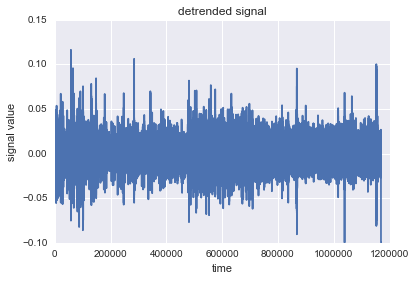

In [20]:
draw_plot(emg_detrend_signal,'detrended signal','time','signal value')

In [21]:
emg_flt_signal = apply_bandpass_filter(emg_detrend_signal)

In [22]:
# ректефикация  сигнала
emg_flt_signal = rec_signal(emg_flt_signal)

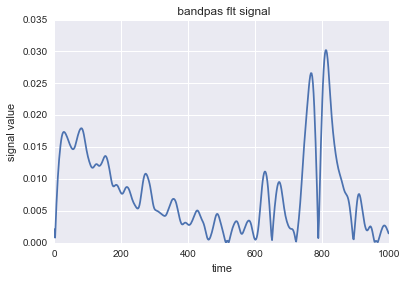

In [23]:
# draw only fist N observations  
draw_plot(emg_flt_signal.head(n=500),' bandpas flt signal','time','signal value')

In [24]:
emg_flt_signal1 = apply_iir_filter(emg_flt_signal,btype = 'low')

In [25]:
peak_indexes = find_peaks(emg_flt_signal1.head(n=1500))

In [26]:
peak_indexes

array([  32,  134,  320,  403,  538,  630,  713,  824,  899,  940,  995,
       1037, 1124, 1198, 1316, 1392, 1415], dtype=int64)

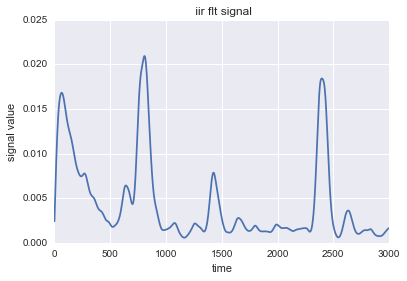

In [27]:
# draw only fist N observations  
draw_plot(emg_flt_signal1.head(n=1500),' iir flt signal','time','signal value')

In [28]:
emg_flt_signal2 = apply_fir_filter(emg_flt_signal,btype = 'low')

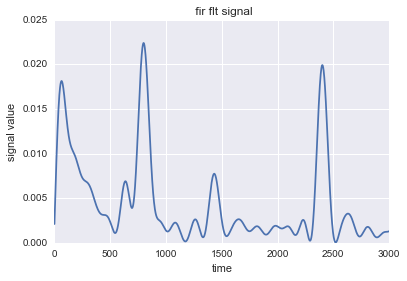

In [29]:
# draw only fist N observations  
draw_plot(emg_flt_signal2.head(n=1500),' fir flt signal','time','signal value')

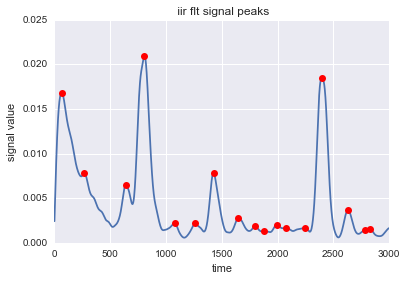

In [30]:
draw_picks(emg_flt_signal1.head(n=1500),peak_indexes,
           ' iir flt signal peaks','time','signal value')

In [31]:
'''
    The simplest method to authomatically detect the onset in the EMG signal is based on amplitude threshold, 
    where the EMG signal is considered to be 'on' when it is above a certain threshold. 
    This threshold is usually proportional to the amplitude of the baseline 
    (the part of the EMG signal that we know there is no muscle activation), for example, 
    a threshold equals to three times the standard deviation of the baseline. 
    To avoid the detection of spikes in the EMG signal, a second threshold can be used imposing that the signal 
    should be above the threshold for at least a certain period (number of samples).
    The raw EMG signal can not be analysed for the onset detection based on amplitude threshold 
    because its amplitude varies from positive to negative very fast. 
    The linear envelope of the EMG signal is usually analysed or the amplitude detection is performed 
    in terms of the standard deviation or RMS of the signal.
'''
threshold = 1/3
emg_label = 'EMGZ' if 'EMGZ' in edf_data_frame.columns else 'EMGC'
threshold = threshold*np.std(emg_flt_signal1[emg_label].values[200:500])
print(threshold)
window=50
onset_indexes = find_onset(emg_flt_signal1.head(n=500),threshold=threshold,
                    n_above=window, n_below=10)

0.00196807092038


In [32]:
onset_indexes

array([[  0, 252],
       [273, 473]], dtype=int64)

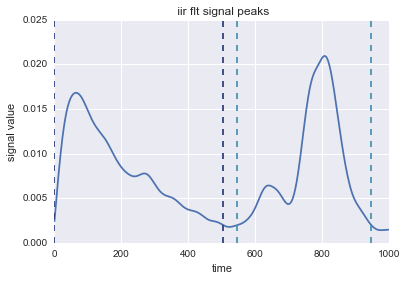

In [33]:
draw_onset(emg_flt_signal1.head(n=500),onset_indexes,
           ' iir flt signal peaks','time','signal value')